# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

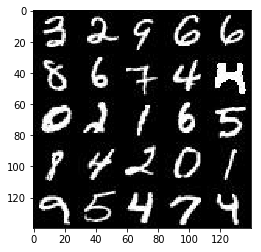

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

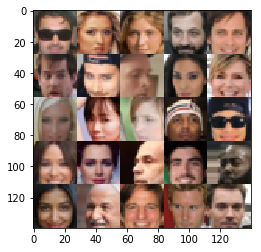

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                 name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 32x32x3
        # Build layer 1:
        # - CNN depth to 64, conv (not transposed) to 16x16 by stride=2
        # - No Leaky ReLU (creates artefacts)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(x1 * alpha, x1)
        # Layer 1 now 16x16x64

        # Build layer 2:
        # - CNN depth to 128, conv (not transposed) to 8x8 by stride=2
        # - batch normalisation
        # - Leaky ReLU
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)
        # Layer 2 now 8x8x64

        # Build layer 3:
        # - CNN depth to 256, conv (not transposed) to 4x4 by stride=2
        # - Leaky ReLU
        x3 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x2, training=True)
        x3 = tf.maximum(x3 * alpha, x3)
        # Layer 2 now 4x4x256

        # Final layer 4:
        # - flatten, reshape to one long vector 
        # - get logits from dense layer
        # get outputs
        x4 = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: The leakage amount from the relus.
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        print("input: ",z)
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        print("Layer 1", h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        print("Layer 2", h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        print("Layer 3", h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=1, padding='same')
        out = tf.tanh(logits)
        print("Output: ", out)
        print("")
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

input:  Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
Layer 1 Tensor("Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Layer 3 Tensor("Maximum_2:0", shape=(?, 28, 28, 128), dtype=float32)
Output:  Tensor("Tanh:0", shape=(?, 28, 28, 5), dtype=float32)

input:  Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
Layer 1 Tensor("Maximum_3:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("Maximum_4:0", shape=(?, 14, 14, 256), dtype=float32)
Layer 3 Tensor("Maximum_5:0", shape=(?, 28, 28, 128), dtype=float32)
Output:  Tensor("Tanh_1:0", shape=(?, 28, 28, 5), dtype=float32)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

input:  Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
Layer 1 Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Layer 3 Tensor("generator/Maximum_2:0", shape=(?, 28, 28, 128), dtype=float32)
Output:  Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, 
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: 
    
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
      
    # unpack parameters from data_shape
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height,
                                           image_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    count = 0
    show_every = 200
    print_every = 20
    number_images_to_display = 12
    
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    saver = tf.train.Saver(var_list=g_vars)       



    print("Training model")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("Count: {}".format(count))
            for batch_images in get_batches(batch_size):
                count += 1
                
                # TODO: Train Model
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})

                if count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:
                                                batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Count: {}:".format(count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if count % show_every == 0:
                    show_generator_output(sess, number_images_to_display, input_z, image_channels, data_image_mode)                   
                    
        print("Training complete")

       

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Layer 3 Tensor("generator/Maximum_2:0", shape=(?, 28, 28, 128), dtype=float32)
Output:  Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)

Training model
Count: 0
Epoch 1/2... Count: 20: Discriminator Loss: 0.5439... Generator Loss: 1.6285
Epoch 1/2... Count: 40: Discriminator Loss: 0.6105... Generator Loss: 1.9864
Epoch 1/2... Count: 60: Discriminator Loss: 0.2090... Generator Loss: 2.4215
Epoch 1/2... Count: 80: Discriminator Loss: 0.3262... Generator Loss: 2.2172
Epoch 1/2... Count: 100: Discriminator Loss: 1.1550... Generator Loss: 1.0461
Epoch 1/2... Count: 120: Discriminator Loss: 0.6997... Generator Loss: 1.1327
Epoch 1/2... Count: 140: Discriminator Loss: 0.3468... Generator Loss: 1.9862
Epoch 1/2... Count: 160: Discriminator Loss: 0.2152... Generator Los

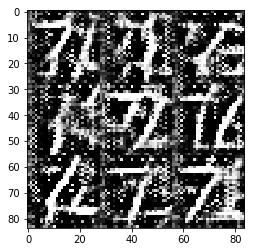

Epoch 1/2... Count: 220: Discriminator Loss: 0.0845... Generator Loss: 3.4175
Epoch 1/2... Count: 240: Discriminator Loss: 0.1030... Generator Loss: 3.2437
Epoch 1/2... Count: 260: Discriminator Loss: 0.4853... Generator Loss: 1.3027
Epoch 1/2... Count: 280: Discriminator Loss: 0.2252... Generator Loss: 3.0419
Epoch 1/2... Count: 300: Discriminator Loss: 0.3658... Generator Loss: 2.0095
Epoch 1/2... Count: 320: Discriminator Loss: 0.5845... Generator Loss: 1.4254
Epoch 1/2... Count: 340: Discriminator Loss: 0.5509... Generator Loss: 2.3066
Epoch 1/2... Count: 360: Discriminator Loss: 0.6985... Generator Loss: 2.0951
Epoch 1/2... Count: 380: Discriminator Loss: 0.6761... Generator Loss: 1.3845
Epoch 1/2... Count: 400: Discriminator Loss: 0.7032... Generator Loss: 1.2392
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_2/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_2/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Lay

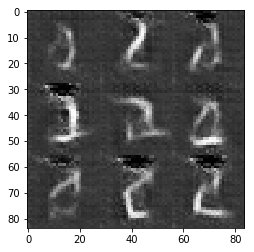

Epoch 1/2... Count: 420: Discriminator Loss: 0.7703... Generator Loss: 1.1124
Epoch 1/2... Count: 440: Discriminator Loss: 0.5429... Generator Loss: 1.2472
Epoch 1/2... Count: 460: Discriminator Loss: 0.5164... Generator Loss: 2.2441
Epoch 1/2... Count: 480: Discriminator Loss: 0.2842... Generator Loss: 2.1220
Epoch 1/2... Count: 500: Discriminator Loss: 0.3847... Generator Loss: 1.4228
Epoch 1/2... Count: 520: Discriminator Loss: 0.7547... Generator Loss: 1.0185
Epoch 1/2... Count: 540: Discriminator Loss: 0.5292... Generator Loss: 1.3632
Epoch 1/2... Count: 560: Discriminator Loss: 0.6870... Generator Loss: 2.7814
Epoch 1/2... Count: 580: Discriminator Loss: 0.3652... Generator Loss: 2.4583
Epoch 1/2... Count: 600: Discriminator Loss: 0.5992... Generator Loss: 1.3418
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_3/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_3/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Lay

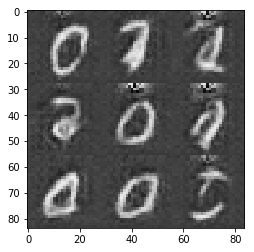

Epoch 1/2... Count: 620: Discriminator Loss: 0.3194... Generator Loss: 2.0304
Epoch 1/2... Count: 640: Discriminator Loss: 0.6707... Generator Loss: 1.0925
Epoch 1/2... Count: 660: Discriminator Loss: 0.6334... Generator Loss: 1.7802
Epoch 1/2... Count: 680: Discriminator Loss: 0.4237... Generator Loss: 1.7977
Epoch 1/2... Count: 700: Discriminator Loss: 0.8759... Generator Loss: 1.2986
Epoch 1/2... Count: 720: Discriminator Loss: 0.7483... Generator Loss: 1.4893
Epoch 1/2... Count: 740: Discriminator Loss: 1.0923... Generator Loss: 0.7277
Epoch 1/2... Count: 760: Discriminator Loss: 0.6611... Generator Loss: 2.0454
Epoch 1/2... Count: 780: Discriminator Loss: 0.8509... Generator Loss: 2.0357
Epoch 1/2... Count: 800: Discriminator Loss: 1.1292... Generator Loss: 1.4591
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_4/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_4/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Lay

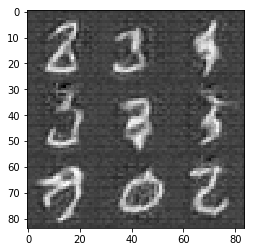

Epoch 1/2... Count: 820: Discriminator Loss: 0.5375... Generator Loss: 2.4784
Epoch 1/2... Count: 840: Discriminator Loss: 0.9970... Generator Loss: 2.3053
Epoch 1/2... Count: 860: Discriminator Loss: 0.7544... Generator Loss: 1.1416
Epoch 1/2... Count: 880: Discriminator Loss: 0.8094... Generator Loss: 0.9383
Epoch 1/2... Count: 900: Discriminator Loss: 0.8557... Generator Loss: 1.2052
Epoch 1/2... Count: 920: Discriminator Loss: 0.6752... Generator Loss: 1.4083
Count: 937
Epoch 2/2... Count: 940: Discriminator Loss: 3.0164... Generator Loss: 3.0712
Epoch 2/2... Count: 960: Discriminator Loss: 0.9715... Generator Loss: 1.0194
Epoch 2/2... Count: 980: Discriminator Loss: 1.2128... Generator Loss: 1.5798
Epoch 2/2... Count: 1000: Discriminator Loss: 0.7059... Generator Loss: 1.3829
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_5/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_5/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

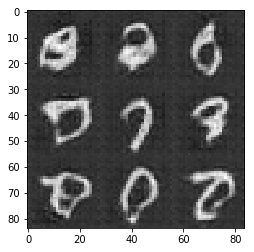

Epoch 2/2... Count: 1020: Discriminator Loss: 0.8440... Generator Loss: 1.3008
Epoch 2/2... Count: 1040: Discriminator Loss: 0.9312... Generator Loss: 0.9983
Epoch 2/2... Count: 1060: Discriminator Loss: 0.4060... Generator Loss: 1.5956
Epoch 2/2... Count: 1080: Discriminator Loss: 0.3287... Generator Loss: 2.6231
Epoch 2/2... Count: 1100: Discriminator Loss: 0.9749... Generator Loss: 0.9554
Epoch 2/2... Count: 1120: Discriminator Loss: 0.6354... Generator Loss: 2.1666
Epoch 2/2... Count: 1140: Discriminator Loss: 0.8670... Generator Loss: 1.0130
Epoch 2/2... Count: 1160: Discriminator Loss: 0.8601... Generator Loss: 1.0404
Epoch 2/2... Count: 1180: Discriminator Loss: 0.7382... Generator Loss: 2.2127
Epoch 2/2... Count: 1200: Discriminator Loss: 0.5362... Generator Loss: 1.3014
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_6/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_6/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

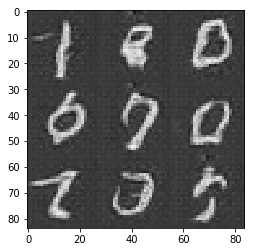

Epoch 2/2... Count: 1220: Discriminator Loss: 0.3200... Generator Loss: 2.2819
Epoch 2/2... Count: 1240: Discriminator Loss: 1.0212... Generator Loss: 0.9825
Epoch 2/2... Count: 1260: Discriminator Loss: 1.2203... Generator Loss: 0.4887
Epoch 2/2... Count: 1280: Discriminator Loss: 0.8969... Generator Loss: 0.9756
Epoch 2/2... Count: 1300: Discriminator Loss: 0.8069... Generator Loss: 1.2091
Epoch 2/2... Count: 1320: Discriminator Loss: 0.7132... Generator Loss: 1.1661
Epoch 2/2... Count: 1340: Discriminator Loss: 1.5007... Generator Loss: 0.5870
Epoch 2/2... Count: 1360: Discriminator Loss: 0.8840... Generator Loss: 2.0563
Epoch 2/2... Count: 1380: Discriminator Loss: 1.3139... Generator Loss: 0.5894
Epoch 2/2... Count: 1400: Discriminator Loss: 1.4974... Generator Loss: 0.4239
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_7/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_7/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

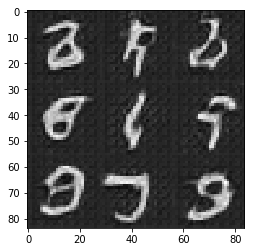

Epoch 2/2... Count: 1420: Discriminator Loss: 0.6259... Generator Loss: 1.7588
Epoch 2/2... Count: 1440: Discriminator Loss: 0.6455... Generator Loss: 2.1661
Epoch 2/2... Count: 1460: Discriminator Loss: 0.9807... Generator Loss: 0.8357
Epoch 2/2... Count: 1480: Discriminator Loss: 0.6961... Generator Loss: 1.6731
Epoch 2/2... Count: 1500: Discriminator Loss: 0.7200... Generator Loss: 2.8746
Epoch 2/2... Count: 1520: Discriminator Loss: 0.9276... Generator Loss: 0.9459
Epoch 2/2... Count: 1540: Discriminator Loss: 0.6281... Generator Loss: 1.7262
Epoch 2/2... Count: 1560: Discriminator Loss: 0.8541... Generator Loss: 1.4734
Epoch 2/2... Count: 1580: Discriminator Loss: 0.8074... Generator Loss: 1.2391
Epoch 2/2... Count: 1600: Discriminator Loss: 0.5000... Generator Loss: 1.7568
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_8/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_8/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

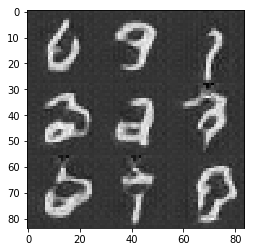

Epoch 2/2... Count: 1620: Discriminator Loss: 0.6853... Generator Loss: 1.1353
Epoch 2/2... Count: 1640: Discriminator Loss: 0.4902... Generator Loss: 1.6903
Epoch 2/2... Count: 1660: Discriminator Loss: 1.6499... Generator Loss: 1.5958
Epoch 2/2... Count: 1680: Discriminator Loss: 0.9555... Generator Loss: 1.0983
Epoch 2/2... Count: 1700: Discriminator Loss: 1.1590... Generator Loss: 0.9600
Epoch 2/2... Count: 1720: Discriminator Loss: 0.5320... Generator Loss: 1.7513
Epoch 2/2... Count: 1740: Discriminator Loss: 0.9443... Generator Loss: 1.1213
Epoch 2/2... Count: 1760: Discriminator Loss: 1.1559... Generator Loss: 1.7718
Epoch 2/2... Count: 1780: Discriminator Loss: 0.6402... Generator Loss: 1.3327
Epoch 2/2... Count: 1800: Discriminator Loss: 1.0620... Generator Loss: 0.8399
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_9/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_9/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

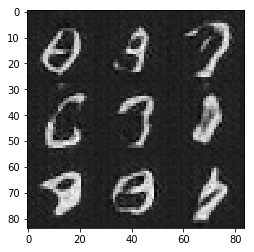

Epoch 2/2... Count: 1820: Discriminator Loss: 1.0898... Generator Loss: 0.8178
Epoch 2/2... Count: 1840: Discriminator Loss: 0.8293... Generator Loss: 1.1948
Epoch 2/2... Count: 1860: Discriminator Loss: 0.7447... Generator Loss: 1.0777
Training complete


In [45]:
batch_size = 64
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Layer 3 Tensor("generator/Maximum_2:0", shape=(?, 28, 28, 128), dtype=float32)
Output:  Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32)

Training model
Count: 0
Epoch 1/1... Count: 20: Discriminator Loss: 1.5628... Generator Loss: 0.4446
Epoch 1/1... Count: 40: Discriminator Loss: 1.4590... Generator Loss: 0.8491
Epoch 1/1... Count: 60: Discriminator Loss: 1.8167... Generator Loss: 1.5494
Epoch 1/1... Count: 80: Discriminator Loss: 0.6135... Generator Loss: 1.5683
Epoch 1/1... Count: 100: Discriminator Loss: 0.9491... Generator Loss: 1.4251
Epoch 1/1... Count: 120: Discriminator Loss: 0.5308... Generator Loss: 1.4479
Epoch 1/1... Count: 140: Discriminator Loss: 0.3777... Generator Loss: 1.8369
Epoch 1/1... Count: 160: Discriminator Loss: 0.5314... Generator Los

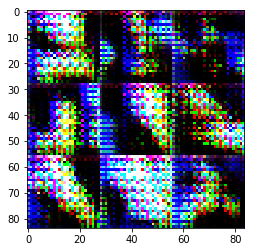

Epoch 1/1... Count: 220: Discriminator Loss: 0.1339... Generator Loss: 3.1917
Epoch 1/1... Count: 240: Discriminator Loss: 0.1169... Generator Loss: 3.5091
Epoch 1/1... Count: 260: Discriminator Loss: 1.0610... Generator Loss: 0.9762
Epoch 1/1... Count: 280: Discriminator Loss: 0.5965... Generator Loss: 1.3790
Epoch 1/1... Count: 300: Discriminator Loss: 0.3781... Generator Loss: 1.8597
Epoch 1/1... Count: 320: Discriminator Loss: 0.2869... Generator Loss: 2.1074
Epoch 1/1... Count: 340: Discriminator Loss: 1.0533... Generator Loss: 4.0438
Epoch 1/1... Count: 360: Discriminator Loss: 0.5300... Generator Loss: 1.4002
Epoch 1/1... Count: 380: Discriminator Loss: 0.5275... Generator Loss: 1.7531
Epoch 1/1... Count: 400: Discriminator Loss: 0.4119... Generator Loss: 1.9995
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_2/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_2/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Lay

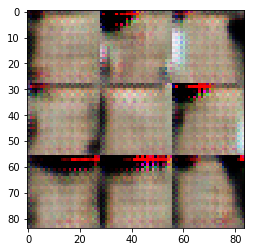

Epoch 1/1... Count: 420: Discriminator Loss: 0.5053... Generator Loss: 1.8137
Epoch 1/1... Count: 440: Discriminator Loss: 0.4897... Generator Loss: 1.6005
Epoch 1/1... Count: 460: Discriminator Loss: 0.2929... Generator Loss: 2.2201
Epoch 1/1... Count: 480: Discriminator Loss: 0.4772... Generator Loss: 1.5277
Epoch 1/1... Count: 500: Discriminator Loss: 0.6469... Generator Loss: 1.3000
Epoch 1/1... Count: 520: Discriminator Loss: 1.4006... Generator Loss: 2.4789
Epoch 1/1... Count: 540: Discriminator Loss: 1.0691... Generator Loss: 0.6789
Epoch 1/1... Count: 560: Discriminator Loss: 0.3547... Generator Loss: 1.6793
Epoch 1/1... Count: 580: Discriminator Loss: 0.3847... Generator Loss: 1.6110
Epoch 1/1... Count: 600: Discriminator Loss: 0.5768... Generator Loss: 2.5389
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_3/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_3/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Lay

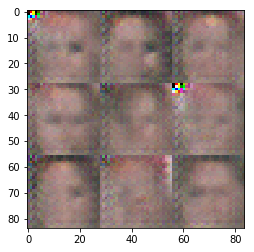

Epoch 1/1... Count: 620: Discriminator Loss: 1.3527... Generator Loss: 3.0394
Epoch 1/1... Count: 640: Discriminator Loss: 0.3502... Generator Loss: 2.7221
Epoch 1/1... Count: 660: Discriminator Loss: 0.3348... Generator Loss: 1.9955
Epoch 1/1... Count: 680: Discriminator Loss: 0.3219... Generator Loss: 2.0056
Epoch 1/1... Count: 700: Discriminator Loss: 0.2448... Generator Loss: 2.4311
Epoch 1/1... Count: 720: Discriminator Loss: 0.2489... Generator Loss: 2.4188
Epoch 1/1... Count: 740: Discriminator Loss: 0.2111... Generator Loss: 2.5561
Epoch 1/1... Count: 760: Discriminator Loss: 1.5853... Generator Loss: 3.0233
Epoch 1/1... Count: 780: Discriminator Loss: 0.1549... Generator Loss: 2.8403
Epoch 1/1... Count: 800: Discriminator Loss: 0.1823... Generator Loss: 2.9720
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_4/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_4/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
Lay

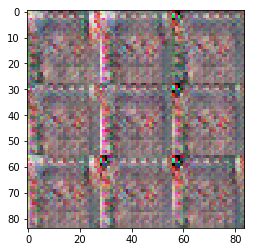

Epoch 1/1... Count: 820: Discriminator Loss: 0.1296... Generator Loss: 3.1846
Epoch 1/1... Count: 840: Discriminator Loss: 0.1285... Generator Loss: 3.0420
Epoch 1/1... Count: 860: Discriminator Loss: 0.8965... Generator Loss: 0.7853
Epoch 1/1... Count: 880: Discriminator Loss: 0.0905... Generator Loss: 3.0683
Epoch 1/1... Count: 900: Discriminator Loss: 0.0871... Generator Loss: 3.3590
Epoch 1/1... Count: 920: Discriminator Loss: 0.4034... Generator Loss: 2.3741
Epoch 1/1... Count: 940: Discriminator Loss: 0.2533... Generator Loss: 2.4329
Epoch 1/1... Count: 960: Discriminator Loss: 0.1001... Generator Loss: 3.1734
Epoch 1/1... Count: 980: Discriminator Loss: 1.5203... Generator Loss: 0.5675
Epoch 1/1... Count: 1000: Discriminator Loss: 0.5336... Generator Loss: 2.5498
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_5/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_5/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
La

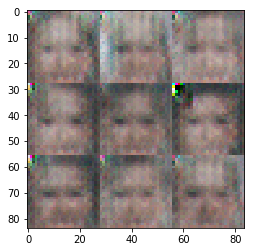

Epoch 1/1... Count: 1020: Discriminator Loss: 0.7005... Generator Loss: 4.6697
Epoch 1/1... Count: 1040: Discriminator Loss: 0.3198... Generator Loss: 3.3214
Epoch 1/1... Count: 1060: Discriminator Loss: 1.7679... Generator Loss: 2.1941
Epoch 1/1... Count: 1080: Discriminator Loss: 0.4256... Generator Loss: 3.5126
Epoch 1/1... Count: 1100: Discriminator Loss: 0.8267... Generator Loss: 1.1175
Epoch 1/1... Count: 1120: Discriminator Loss: 1.2031... Generator Loss: 0.6093
Epoch 1/1... Count: 1140: Discriminator Loss: 0.5657... Generator Loss: 2.7537
Epoch 1/1... Count: 1160: Discriminator Loss: 1.3112... Generator Loss: 0.7743
Epoch 1/1... Count: 1180: Discriminator Loss: 1.4345... Generator Loss: 0.8650
Epoch 1/1... Count: 1200: Discriminator Loss: 1.2424... Generator Loss: 0.7919
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_6/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_6/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

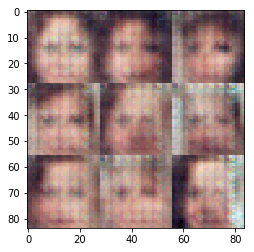

Epoch 1/1... Count: 1220: Discriminator Loss: 1.2585... Generator Loss: 0.7575
Epoch 1/1... Count: 1240: Discriminator Loss: 1.2313... Generator Loss: 0.7541
Epoch 1/1... Count: 1260: Discriminator Loss: 1.2968... Generator Loss: 0.9338
Epoch 1/1... Count: 1280: Discriminator Loss: 1.1080... Generator Loss: 0.9756
Epoch 1/1... Count: 1300: Discriminator Loss: 1.2707... Generator Loss: 0.8781
Epoch 1/1... Count: 1320: Discriminator Loss: 1.1935... Generator Loss: 0.8039
Epoch 1/1... Count: 1340: Discriminator Loss: 1.4183... Generator Loss: 0.8374
Epoch 1/1... Count: 1360: Discriminator Loss: 1.3564... Generator Loss: 0.7301
Epoch 1/1... Count: 1380: Discriminator Loss: 1.1761... Generator Loss: 0.9523
Epoch 1/1... Count: 1400: Discriminator Loss: 1.2275... Generator Loss: 0.8369
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_7/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_7/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

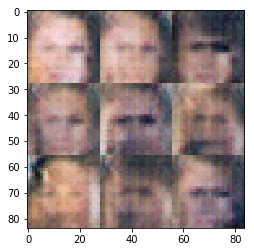

Epoch 1/1... Count: 1420: Discriminator Loss: 1.2624... Generator Loss: 0.6504
Epoch 1/1... Count: 1440: Discriminator Loss: 1.4123... Generator Loss: 0.6206
Epoch 1/1... Count: 1460: Discriminator Loss: 1.1379... Generator Loss: 0.8977
Epoch 1/1... Count: 1480: Discriminator Loss: 1.1827... Generator Loss: 0.8711
Epoch 1/1... Count: 1500: Discriminator Loss: 1.2713... Generator Loss: 0.7465
Epoch 1/1... Count: 1520: Discriminator Loss: 1.2968... Generator Loss: 0.7047
Epoch 1/1... Count: 1540: Discriminator Loss: 1.3287... Generator Loss: 0.7223
Epoch 1/1... Count: 1560: Discriminator Loss: 1.4708... Generator Loss: 0.5592
Epoch 1/1... Count: 1580: Discriminator Loss: 1.2453... Generator Loss: 0.7578
Epoch 1/1... Count: 1600: Discriminator Loss: 1.3275... Generator Loss: 0.6883
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_8/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_8/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

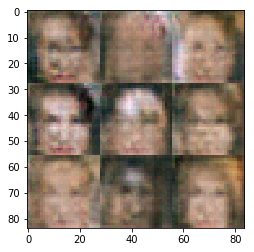

Epoch 1/1... Count: 1620: Discriminator Loss: 1.3545... Generator Loss: 0.7783
Epoch 1/1... Count: 1640: Discriminator Loss: 1.2654... Generator Loss: 0.8505
Epoch 1/1... Count: 1660: Discriminator Loss: 1.2876... Generator Loss: 0.9032
Epoch 1/1... Count: 1680: Discriminator Loss: 1.3859... Generator Loss: 0.7299
Epoch 1/1... Count: 1700: Discriminator Loss: 1.3222... Generator Loss: 0.7018
Epoch 1/1... Count: 1720: Discriminator Loss: 1.3464... Generator Loss: 0.7521
Epoch 1/1... Count: 1740: Discriminator Loss: 1.3293... Generator Loss: 0.7428
Epoch 1/1... Count: 1760: Discriminator Loss: 1.3282... Generator Loss: 0.7471
Epoch 1/1... Count: 1780: Discriminator Loss: 1.2631... Generator Loss: 0.8073
Epoch 1/1... Count: 1800: Discriminator Loss: 1.4555... Generator Loss: 0.7177
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_9/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_9/Maximum_1:0", shape=(?, 14, 14, 256), dtype=fl

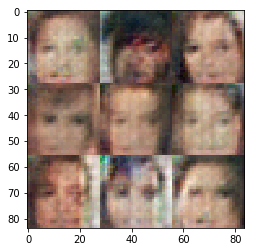

Epoch 1/1... Count: 1820: Discriminator Loss: 1.4336... Generator Loss: 0.7193
Epoch 1/1... Count: 1840: Discriminator Loss: 1.3452... Generator Loss: 0.7566
Epoch 1/1... Count: 1860: Discriminator Loss: 1.5076... Generator Loss: 0.9808
Epoch 1/1... Count: 1880: Discriminator Loss: 1.3496... Generator Loss: 0.7137
Epoch 1/1... Count: 1900: Discriminator Loss: 1.3446... Generator Loss: 0.8001
Epoch 1/1... Count: 1920: Discriminator Loss: 1.4345... Generator Loss: 0.6253
Epoch 1/1... Count: 1940: Discriminator Loss: 1.3540... Generator Loss: 0.6774
Epoch 1/1... Count: 1960: Discriminator Loss: 1.3851... Generator Loss: 0.5683
Epoch 1/1... Count: 1980: Discriminator Loss: 1.4820... Generator Loss: 0.8171
Epoch 1/1... Count: 2000: Discriminator Loss: 1.4759... Generator Loss: 0.5580
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_10/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_10/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

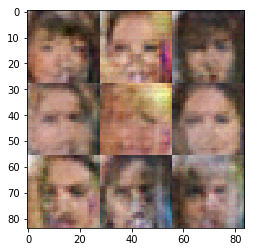

Epoch 1/1... Count: 2020: Discriminator Loss: 1.3378... Generator Loss: 0.6582
Epoch 1/1... Count: 2040: Discriminator Loss: 1.3996... Generator Loss: 0.6439
Epoch 1/1... Count: 2060: Discriminator Loss: 1.4040... Generator Loss: 0.7598
Epoch 1/1... Count: 2080: Discriminator Loss: 1.4554... Generator Loss: 0.6341
Epoch 1/1... Count: 2100: Discriminator Loss: 1.4120... Generator Loss: 0.7458
Epoch 1/1... Count: 2120: Discriminator Loss: 1.4256... Generator Loss: 0.6522
Epoch 1/1... Count: 2140: Discriminator Loss: 1.3846... Generator Loss: 0.5787
Epoch 1/1... Count: 2160: Discriminator Loss: 1.4496... Generator Loss: 0.5559
Epoch 1/1... Count: 2180: Discriminator Loss: 1.3860... Generator Loss: 0.7823
Epoch 1/1... Count: 2200: Discriminator Loss: 1.3564... Generator Loss: 0.6588
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_11/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_11/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

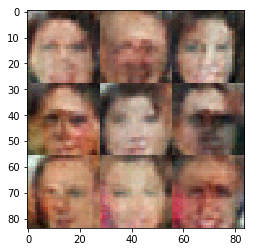

Epoch 1/1... Count: 2220: Discriminator Loss: 1.2996... Generator Loss: 0.7506
Epoch 1/1... Count: 2240: Discriminator Loss: 1.3439... Generator Loss: 0.8228
Epoch 1/1... Count: 2260: Discriminator Loss: 1.3715... Generator Loss: 0.6213
Epoch 1/1... Count: 2280: Discriminator Loss: 1.4466... Generator Loss: 0.5375
Epoch 1/1... Count: 2300: Discriminator Loss: 1.3702... Generator Loss: 0.7539
Epoch 1/1... Count: 2320: Discriminator Loss: 1.4341... Generator Loss: 0.7482
Epoch 1/1... Count: 2340: Discriminator Loss: 1.4094... Generator Loss: 0.6054
Epoch 1/1... Count: 2360: Discriminator Loss: 1.4306... Generator Loss: 0.6332
Epoch 1/1... Count: 2380: Discriminator Loss: 1.5035... Generator Loss: 0.4728
Epoch 1/1... Count: 2400: Discriminator Loss: 1.4337... Generator Loss: 0.7341
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_12/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_12/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

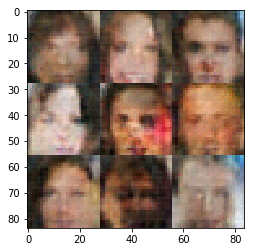

Epoch 1/1... Count: 2420: Discriminator Loss: 1.4205... Generator Loss: 0.6835
Epoch 1/1... Count: 2440: Discriminator Loss: 1.3639... Generator Loss: 0.6732
Epoch 1/1... Count: 2460: Discriminator Loss: 1.4681... Generator Loss: 0.5839
Epoch 1/1... Count: 2480: Discriminator Loss: 1.4594... Generator Loss: 0.6304
Epoch 1/1... Count: 2500: Discriminator Loss: 1.4245... Generator Loss: 0.5784
Epoch 1/1... Count: 2520: Discriminator Loss: 1.3875... Generator Loss: 0.7054
Epoch 1/1... Count: 2540: Discriminator Loss: 1.4184... Generator Loss: 0.6514
Epoch 1/1... Count: 2560: Discriminator Loss: 1.4380... Generator Loss: 0.6619
Epoch 1/1... Count: 2580: Discriminator Loss: 1.5196... Generator Loss: 0.5298
Epoch 1/1... Count: 2600: Discriminator Loss: 1.4818... Generator Loss: 0.5298
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_13/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_13/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

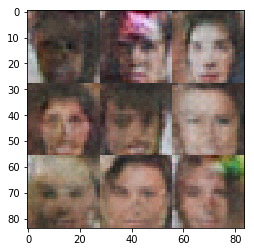

Epoch 1/1... Count: 2620: Discriminator Loss: 1.5519... Generator Loss: 0.6445
Epoch 1/1... Count: 2640: Discriminator Loss: 1.4533... Generator Loss: 0.6953
Epoch 1/1... Count: 2660: Discriminator Loss: 1.4754... Generator Loss: 0.5547
Epoch 1/1... Count: 2680: Discriminator Loss: 1.4714... Generator Loss: 0.5995
Epoch 1/1... Count: 2700: Discriminator Loss: 1.4063... Generator Loss: 0.6912
Epoch 1/1... Count: 2720: Discriminator Loss: 1.4254... Generator Loss: 0.7653
Epoch 1/1... Count: 2740: Discriminator Loss: 1.3934... Generator Loss: 0.6160
Epoch 1/1... Count: 2760: Discriminator Loss: 1.4394... Generator Loss: 0.6911
Epoch 1/1... Count: 2780: Discriminator Loss: 1.4205... Generator Loss: 0.7058
Epoch 1/1... Count: 2800: Discriminator Loss: 1.4692... Generator Loss: 0.6102
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_14/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_14/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

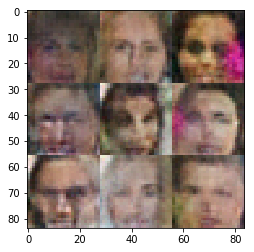

Epoch 1/1... Count: 2820: Discriminator Loss: 1.4651... Generator Loss: 0.6044
Epoch 1/1... Count: 2840: Discriminator Loss: 1.4877... Generator Loss: 0.6228
Epoch 1/1... Count: 2860: Discriminator Loss: 1.4720... Generator Loss: 0.5668
Epoch 1/1... Count: 2880: Discriminator Loss: 1.4358... Generator Loss: 0.6875
Epoch 1/1... Count: 2900: Discriminator Loss: 1.5089... Generator Loss: 0.6396
Epoch 1/1... Count: 2920: Discriminator Loss: 1.4296... Generator Loss: 0.6362
Epoch 1/1... Count: 2940: Discriminator Loss: 1.4425... Generator Loss: 0.5778
Epoch 1/1... Count: 2960: Discriminator Loss: 1.4155... Generator Loss: 0.6877
Epoch 1/1... Count: 2980: Discriminator Loss: 1.4186... Generator Loss: 0.6849
Epoch 1/1... Count: 3000: Discriminator Loss: 1.4044... Generator Loss: 0.6466
input:  Tensor("input_z:0", shape=(?, 256), dtype=float32)
Layer 1 Tensor("generator_15/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Layer 2 Tensor("generator_15/Maximum_1:0", shape=(?, 14, 14, 256), dtype=

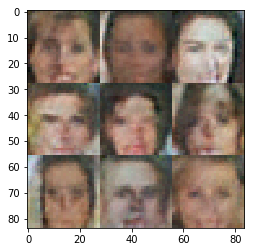

Epoch 1/1... Count: 3020: Discriminator Loss: 1.5260... Generator Loss: 0.5569
Epoch 1/1... Count: 3040: Discriminator Loss: 1.4186... Generator Loss: 0.5803
Epoch 1/1... Count: 3060: Discriminator Loss: 1.3750... Generator Loss: 0.7361
Epoch 1/1... Count: 3080: Discriminator Loss: 1.4543... Generator Loss: 0.6149
Epoch 1/1... Count: 3100: Discriminator Loss: 1.4586... Generator Loss: 0.6495
Epoch 1/1... Count: 3120: Discriminator Loss: 1.4730... Generator Loss: 0.6485
Epoch 1/1... Count: 3140: Discriminator Loss: 1.4051... Generator Loss: 0.6883
Epoch 1/1... Count: 3160: Discriminator Loss: 1.4357... Generator Loss: 0.6332
Training complete


In [46]:
batch_size = 64
z_dim = 256
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.